# Using Autoencoder architecture to create latent representation of 1024 time domain scans

## Proposed Approaches
1. Classic Classification on encoder-decoder latent vector  
- Train encoder-decoder on reconstruction task  
- Train FCNN to classify the pulses  

2. Hybrid network approach  
- Multi-headed network to produce latent space and classify from the latent space  
- Creates a classification focussed embedding  
- Joint loss function (will need loss contributions to be tuned)  

In [5]:
import torch
import numpy as np
from models.Encoder_decoder import Autoencoder,train_autoencoder
from models.utils import identify_device, load_thz_dataset
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load THz pulse dataset (assumes each sample is a 1D tensor of size 1024)
data = torch.load("Synthetic_data_60k.pt", weights_only=False)
synthetic_data = data["synthetic_data"]  # [N, 1024]

synthetic_data.shape

torch.Size([60000, 1024])

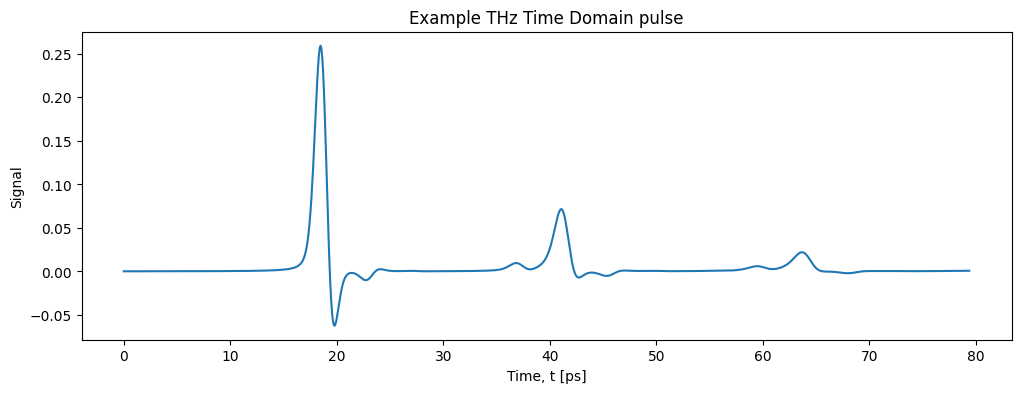

In [9]:
deltat = 0.0194e-12 * 4 # 4x multiple from the downsampling during dataset production
L = synthetic_data.shape[1]
t_axis = np.arange(0, L*deltat, deltat)

plt.figure(figsize=(12,4))
plt.title('Example THz Time Domain pulse')
plt.plot(t_axis*1e12, synthetic_data[0])
plt.ylabel('Signal')
plt.xlabel('Time, t [ps]')
plt.show()

In [3]:
# Create DataLoader
dataset = TensorDataset(synthetic_data)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Model + training
model = Autoencoder(input_dim=1024, latent_dim=32)
device = identify_device()
train_autoencoder(model, loader, device, num_epochs=10)

Using device: mps
Epoch 1: Loss = 0.0003
Epoch 2: Loss = 0.0000
Epoch 3: Loss = 0.0000
Epoch 4: Loss = 0.0000
Epoch 5: Loss = 0.0000
Epoch 6: Loss = 0.0000
Epoch 7: Loss = 0.0000
Epoch 8: Loss = 0.0000
Epoch 9: Loss = 0.0000
Epoch 10: Loss = 0.0000
